## Código de estudio de relación de datos de oleaje y viento



In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import xarray as xr
from mikeio import Dfs0
from mikeio import Dfs2
import pandas as pd
import funciones as fn

def plot_spectra2D(data, time):
    '''
    Data: mikeio.DataSet 
            hint: Dfs2("text").read()
    time: int
    '''
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    # Make data.
    X = np.arange(0, data.shape[2], 1)
    Y = np.arange(0, data.shape[2], 1)
    X, Y = np.meshgrid(X, Y)
    Z = data.isel([time],axis=0)[0][0]
    
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    
    # Customize the z axis.
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()    
    
def plot_spectra_polar(data, time):

    deltaf= data.i[1]-data.i[0]
    f=[]
    for i in range(len(data.i)):
        if deltaf<1:
            f.append(float(data.i[0] + i*deltaf))
        else:
            f.append(float(data.i[0]*deltaf**i))

    df = pd.DataFrame(columns = data.j, index = [1/freq for freq in f], 
                        data =np.array(data["Wave energy density"][time,:,:]))    

    return fn.plot_spectra(df, item = None, tstep = None, 
                 figsize = (8,8), cmap = 'viridis', cbar = False, cbar_label = None, 
                 levels = 'auto', ax = None, extend = 'both',
                 watermark = None, prdw_logo_path = None, 
                 prdw_logo_size = [0.69, 0.75, 0.15, 0.15], 
                 prdw_logo_alpha = 0.5, fig = None)
    
def plot_waves(dataframe, variable, fecha_inicial, fecha_final):
    '''
    dataframe: dataframe. 
            hint: dataframe = Dfs0("text.dfs0").read().to_dataframe()
    variable: string
    fecha_inicial: string 
    fecha_final: string
    
    Example: plot_waves(df,"Hm0","2000-12-1","2001-12-2")
    '''
    a = dataframe[variable][fecha_inicial:fecha_final]
    
    if str(variable)=="Hm0":
        tit= "Altura ola"; label="metros"
    elif str(variable) == "Tp":
        tit= "Periodo ola"; label="segundos"
    elif str(variable) == "Mean Dir":
        tit= "Dirección ola"; label="grados"
    elif str(variable) == "DSD":  
        tit= "Desviación estándar direccional"; label="grados"
        
    a.plot(xlabel="Tiempo", ylabel=label ,title= f"{tit}, Valparaíso 33S - 72W")
    



def plot_wind(dataserie, variable, time, lat, lon):
    """
    Dataserie: xarray.Dataset
    variable: string
    time: int
    lat = slice
    lon = slice
    """
    return dataserie[variable].isel(time=time).sel(latitude=lat,longitude=lon).plot()



def cut_netcdf(new_file):
    '''
    This function crop the netcdf file in two files and get rid of expver dimension
    return two files without the expver dimension
    '''
    ds2 = xr.open_dataset(new_file)
    times = []
    
    for var in ds2:
        for t in reversed(range(ds2[var].shape[0])):
            if pd.isna(ds2[var].isel(time=t,expver=1))[0,0]:
                print(var," expvar format is 1 until time ",np.array(ds2["time"].isel(time=t)))
                times.append([var,t])
                break
        continue
    print(times)
    
    if times[0][1]==times[1][1]:
        
        rango1 = slice(None, str(np.array(ds2["time"].isel(time=times[0][1]))))
        rango5 = slice(str(np.array(ds2["time"].isel(time=times[0][1]+1))),None)
        
        ds2_era1 = ds2.isel(expver=0).sel(time=rango1).drop('expver',dim=None)
        ds2_era5 = ds2.isel(expver=1).sel(time=rango5).drop('expver',dim=None)
        
        ds2_era1.to_netcdf('cut_netcdf1.nc')
        ds2_era5.to_netcdf('cut_netcdf2.nc')
        
    else:
        return "Time changes of coordinate expvar are diferent for every single variable. further code must be written"+times


#### The data:
##### Wind:
- Specify the path location on "path1" file as string.
- On names list, fill with the names documents.
- if new data is added, you could use "cut:netcdf" function to solve the era5 problem.

##### Waves:
- Specify the path location on "path2" file as string.

In [2]:
#Wind
names = ['Wind_data_part0.nc',
         'Wind_data_part1.nc',
         'Wind_data_part2.nc',
         'Wind_data_part3.1.nc',
         'Wind_data_part3.2.nc']
path1 = "E:/Data/"              #set location of the files
files = [path1 + name for name in names]
dswind= xr.open_mfdataset(files)

In [17]:
#Waves
path2 = "E:/Data/"
dfs0 = Dfs0(path2 + "NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912_check.dfs0")
dfs2 = Dfs2(path2 + "NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912.dfs2")
dswave= xr.open_dataset(path2 + "NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912.nc")

ds0  = dfs0.read()
df0  = dfs0.read().to_dataframe()
ds2  = dfs2.read()

## Wind Dataset

In [3]:
dswind


C:\ProgramData\Anaconda3\lib\site-packages\dask\array\core.py:1314: RuntimeWarning: overflow encountered in long_scalars
  cbytes = format_bytes(np.prod(self.chunksize) * self.dtype.itemsize)


<xarray.Dataset>
Dimensions:    (latitude: 161, longitude: 241, time: 122808)
Coordinates:
  * longitude  (longitude) float32 -130.0 -129.8 -129.5 ... -70.5 -70.25 -70.0
  * latitude   (latitude) float32 -10.0 -10.25 -10.5 ... -49.5 -49.75 -50.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-01-10T21:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(37984, 161, 241), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(37984, 161, 241), meta=np.ndarray>
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(37984, 161, 241), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-01-15 01:01:29 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

## Wave Dataset


In [18]:
dswave



<xarray.Dataset>
Dimensions:              (Timestep: 90584, i: 36, j: 36)
Coordinates:
  * Timestep             (Timestep) datetime64[ns] 1979-01-01T03:00:00 ... 20...
  * i                    (i) float64 0.035 1.135 2.235 ... 36.34 37.44 38.54
  * j                    (j) float64 5.0 15.0 25.0 35.0 ... 335.0 345.0 355.0
    latitude             (i, j) float64 ...
    longitude            (i, j) float64 ...
    easting              (i, j) float64 ...
    northing             (i, j) float64 ...
Data variables:
    Wave energy density  (Timestep, i, j) float64 ...
Attributes:
    AxisUnit:    meter
    Projection:  Latitude:0.0_Longitude:0.0_Orientation:0.0_WkTString:NON-UTM

In [64]:

deltaf= dswave.i[1]-dswave.i[0]
time =1000
f=[]
for i in range(len(dswave.i)):
    if deltaf<1:
        f.append(float(dswave.i[0] + i*deltaf))
    else:
        f.append(float(dswave.i[0]*deltaf**i))

df = pd.DataFrame(columns = dswave.j, index = [1/freq for freq in f], data =np.array(dswave["Wave energy density"][time,:,:]))

In [66]:
import funciones as fn

C:\Users\56993\Desktop\Código\funciones.py:333: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_under('whitesmoke')
C:\Users\56993\Desktop\Código\funciones.py:348: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{}s'.format(x) for x in ax.get_yticks()])


<PolarAxesSubplot:>

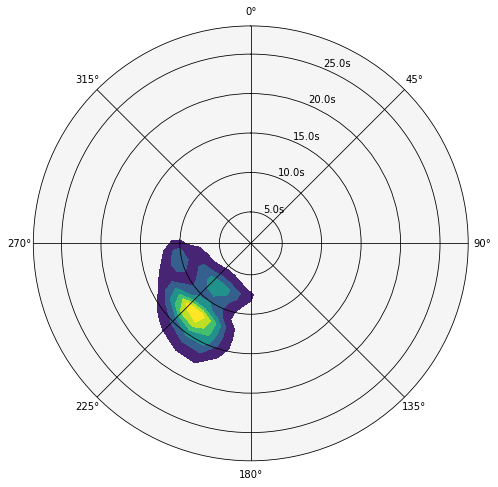

In [88]:

plot_spectra_polar(dswave,19030)